(gallery-tutorial-custom)=

# CustomSource

The {ref}`docu-magpylib-api-custom` class was implemented to offer easy integration of user field implementations into Magpylib's object-oriented interface.

```{note}
Obviously, any field implementation can be integrated. Specifically, fields where superposition holds and interactions do not disturb the sources (e.g. electric, gravitational, ...) can benefit from Magpylib's position and orientation interface.
```

## Magnetic Monopole

In this example we create a class that represents the elusive magnetic monopole, which would have a magnetic field like this

$$
{\bf B} = Q_m \frac{{\bf r}}{|{\bf r}|^3}.
$$

Here the monopole lies in the origin of the local coordinates, $Q_m$ is the monopole charge and ${\bf r}$ is the observer position.

We create this field as a Python function and hand it over to a CustomSource `field_func` argument. The `field_func` input must be a callable with two positional arguments `field` (can be `'B'` or `'H'`) and `observers` (must accept ndarrays of shape (n,3)), and return the respective fields in units of T and A/m in the same shape.

In [1]:
import numpy as np

import magpylib as magpy


# Create monopole field
def mono_field(field, observers):
    """
    Monopole field

    field: string, "B" or "H
        return B or H-field

    observers: array_like of shape (n,3)
        Observer positions

    Returns: np.ndarray, shape (n,3)
        Magnetic monopole field
    """
    Qm = 1e-6  # unit T·m²
    obs = np.array(observers).T  # unit m
    B = Qm * (obs / np.linalg.norm(obs, axis=0) ** 3).T  # unit T
    if field == "B":
        return B  # unit T
    elif field == "H":
        H = B / magpy.mu_0  # unit A/m
        return H
    else:
        raise ValueError("Field Value must be either B or H")


# Create CustomSource with monopole field
mono = magpy.misc.CustomSource(field_func=mono_field)

# Compute field
print(mono.getB((0.001, 0, 0)))
print(mono.getH((0.001, 0, 0)))

[1. 0. 0.]
[795774.71502628      0.              0.        ]


Multiple of these sources can now be combined, making use of the Magpylib position/orientation interface.

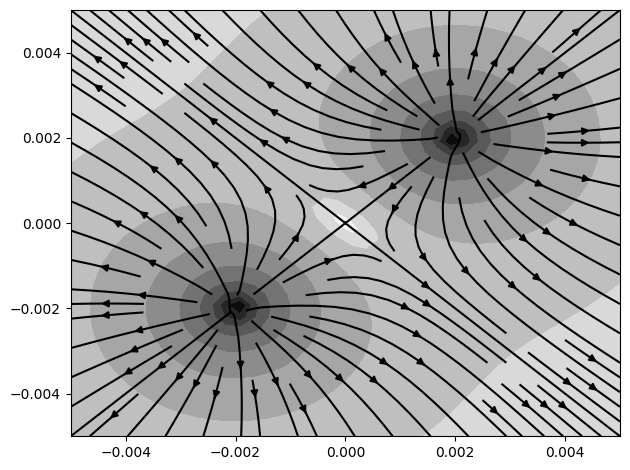

In [2]:
import matplotlib.pyplot as plt

# Create two monopole charges
mono1 = magpy.misc.CustomSource(field_func=mono_field, position=(0.002, 0.002, 0))
mono2 = magpy.misc.CustomSource(field_func=mono_field, position=(-0.002, -0.002, 0))

# Compute field on observer-grid
X, Y = np.mgrid[-0.005:0.005:40j, -0.005:0.005:40j].transpose((0, 2, 1))
grid = np.stack([X, Y, np.zeros((40, 40))], axis=2)
B = magpy.getB([mono1, mono2], grid, sumup=True)
normB = np.linalg.norm(B, axis=2)

# Plot field in x-y symmetry plane
cp = plt.contourf(X, Y, np.log10(normB), cmap="gray_r", levels=10)
plt.streamplot(X, Y, B[:, :, 0], B[:, :, 1], color="k", density=1)

plt.tight_layout()
plt.show()

## Adding a 3D model

While the CustomSource is graphically represented by a simple marker by default, we can easily add a 3D model as described in {ref}`examples-own-3d-models`.

In [3]:
# Load Sphere model
trace_pole = magpy.graphics.model3d.make_Ellipsoid(
    dimension=np.array([3, 3, 3]) * 1e-4,
)

for mono in [mono1, mono2]:
    # Turn off default model
    mono.style.model3d.showdefault = False

    # Add sphere model
    mono.style.model3d.add_trace(trace_pole)

# Display models
magpy.show(mono1, mono2)

## Subclassing CustomSource

In the above example it would be nice to make the CustomSource dynamic, so that it would have a property `charge` that can be changed at will, rather than having to redefine the `field_func` and initialize a new object every time. In the following example we show how to sub-class `CustomSource` to achieve this. The problem is reminiscent of {ref}`gallery-misc-compound`.

In [4]:
class Monopole(magpy.misc.CustomSource):
    """Magnetic Monopole class

    Parameters
    ----------
    charge: float
        Monopole charge in units of T·m²
    """

    def __init__(self, charge, **kwargs):
        super().__init__(**kwargs)  # hand over style kwargs
        self._charge = charge

        # Add spherical 3d model
        trace_pole = magpy.graphics.model3d.make_Ellipsoid(
            dimension=np.array([3, 3, 3]) * 1e-4,
        )
        self.style.model3d.showdefault = False
        self.style.model3d.add_trace(trace_pole)

        # Add monopole field_func
        self._update()

    def _update(self):
        """Apply monopole field function"""

        def mono_field(field, observers):
            """monopole field"""
            Qm = self._charge  # unit T·m²
            obs = np.array(observers).T  # unit m
            B = Qm * (obs / np.linalg.norm(obs, axis=0) ** 3).T  # unit T
            if field == "B":
                return B  # unit T
            elif field == "H":
                H = B / magpy.mu_0  # unit A/m
                return H
            else:
                raise ValueError("Field Value must be either B or H")

        self.style.label = f"Monopole (charge={self._charge} T·m²)"
        self.field_func = mono_field

    @property
    def charge(self):
        """Return charge"""
        return self._charge

    @charge.setter
    def charge(self, input):
        """Set charge"""
        self._charge = input
        self._update()


# Use new class
mono = Monopole(charge=1e-6)
print(mono.getB((0.001, 0, 0)))

# Make use of new property
mono.charge = -1e-6
print(mono.getB((0.001, 0, 0)))

[1. 0. 0.]
[-1.  0.  0.]


The new class seamlessly integrates into the Magpylib interface as we show in the following example where we have a look at the Quadrupole field

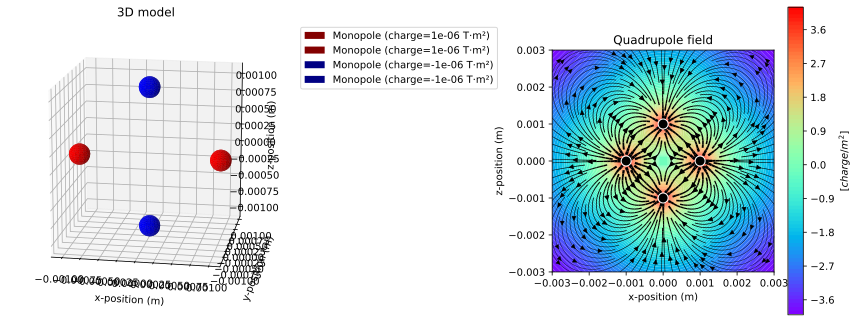

In [5]:
import matplotlib.pyplot as plt

# Create a quadrupole from four monopoles
mono1 = Monopole(charge=1e-6, style_color="r", position=(0.001, 0, 0))
mono2 = Monopole(charge=1e-6, style_color="r", position=(-0.001, 0, 0))
mono3 = Monopole(charge=-1e-6, style_color="b", position=(0, 0, 0.001))
mono4 = Monopole(charge=-1e-6, style_color="b", position=(0, 0, -0.001))
qpole = magpy.Collection(mono1, mono2, mono3, mono4)

# Matplotlib figure with 3d and 2d axis
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_subplot(
    121,
    projection="3d",
    azim=-80,
    elev=15,
)
ax2 = fig.add_subplot(
    122,
)

# Show 3D model in ax1
magpy.show(*qpole, canvas=ax1)

# Compute B-field on xz-grid and display in ax2
ts = np.linspace(-3, 3, 30)
grid = np.array([[(x / 1000, 0, z / 1000) for x in ts] for z in ts])
B = qpole.getB(grid)

scale = np.linalg.norm(B, axis=2)
cp = ax2.contourf(
    grid[:, :, 0],
    grid[:, :, 2],
    np.log(scale),
    levels=100,
    cmap="rainbow",
)
ax2.streamplot(
    grid[:, :, 0],
    grid[:, :, 2],
    B[:, :, 0],
    B[:, :, 2],
    density=2,
    color="k",
    linewidth=scale**0.3,
)

# Display pole position in ax2
pole_pos = np.array([mono.position for mono in qpole])
ax2.plot(
    pole_pos[:, 0],
    pole_pos[:, 2],
    marker="o",
    ms=10,
    mfc="k",
    mec="w",
    ls="",
)

# Figure styling
ax1.set(
    title="3D model",
    xlabel="x-position (m)",
    ylabel="y-position (m)",
    zlabel="z-position (m)",
)
ax2.set(
    title="Quadrupole field",
    xlabel="x-position (m)",
    ylabel="z-position (m)",
    aspect=1,
)
fig.colorbar(cp, label="[$charge/m^2$]", ax=ax2)

plt.tight_layout()
plt.show()